# modeling

The goal of this notebook will be to find an appropriate model to move forward with.  Because this is a general immage classification problem, accuracy will be the success metric used.  There is no reason to prefer misclassification in any direction and enough new images were generated to ensure that each of the 5 classes are well balanced.  An accuracy score of 90+ on the test dataset will be considered a success.

## contents
* [imports and settings](#imports)
* [base cnn](#cnn)
* [hyper-parameter tuning](#hp)

## imports and settings<a id='imports'></a>

In [1]:
import os
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

warnings.filterwarnings("ignore")
%matplotlib inline
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2023-12-11 21:15:56.339640: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-11 21:15:56.359292: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 21:15:56.359314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 21:15:56.359794: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 21:15:56.362951: I tensorflow/core/platform/cpu_feature_guar

## base cnn<a id='cnn'></a>

The first model I will try is a convulutional neural network trained with only the images I have collected.  The first step will be to establish the train and validate sets and setup the generators for TensorFlow.

In [24]:
batch_size = 50 
img_size = (256, 256)

train_dir = '../data/splits/train'
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_dir = '../data/splits/validate'  
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 4000 images belonging to 4 classes.
Found 399 images belonging to 4 classes.


The next step is to define the model in terms of layers.  Each of these selections was arbitrary, a best effort guess at what would give good results.

In [25]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  
])

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Now, we train the model.

In [26]:
epochs=20
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size  
)

Epoch 1/20
80/80 [==============================] - 5s 47ms/step - loss: 1.3630 - accuracy: 0.3095 - val_loss: 1.2296 - val_accuracy: 0.4571
Epoch 2/20
80/80 [==============================] - 4s 46ms/step - loss: 1.1777 - accuracy: 0.4875 - val_loss: 0.9735 - val_accuracy: 0.6514
Epoch 3/20
80/80 [==============================] - 4s 46ms/step - loss: 0.9384 - accuracy: 0.6143 - val_loss: 0.6569 - val_accuracy: 0.7514
Epoch 4/20
80/80 [==============================] - 4s 46ms/step - loss: 0.7621 - accuracy: 0.6988 - val_loss: 0.5873 - val_accuracy: 0.7686
Epoch 5/20
80/80 [==============================] - 4s 46ms/step - loss: 0.6176 - accuracy: 0.7590 - val_loss: 0.4278 - val_accuracy: 0.8571
Epoch 6/20
80/80 [==============================] - 4s 45ms/step - loss: 0.4708 - accuracy: 0.8223 - val_loss: 0.5281 - val_accuracy: 0.7914
Epoch 7/20
80/80 [==============================] - 4s 46ms/step - loss: 0.3713 - accuracy: 0.8583 - val_loss: 0.3496 - val_accuracy: 0.8829
Epoch 8/20
80

89% accuracy and 0.3218 loss on the validation set seems promising.  

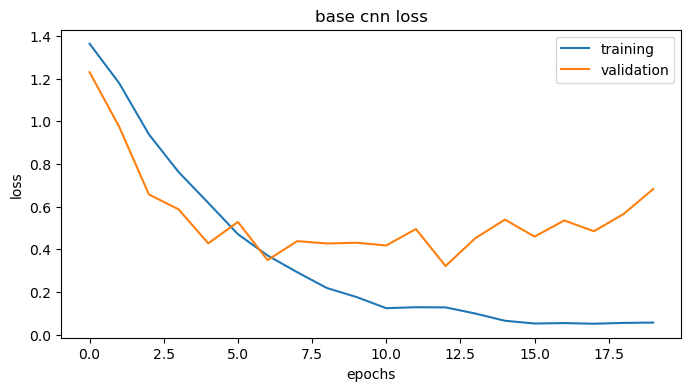

In [29]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')

plt.title('base cnn loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

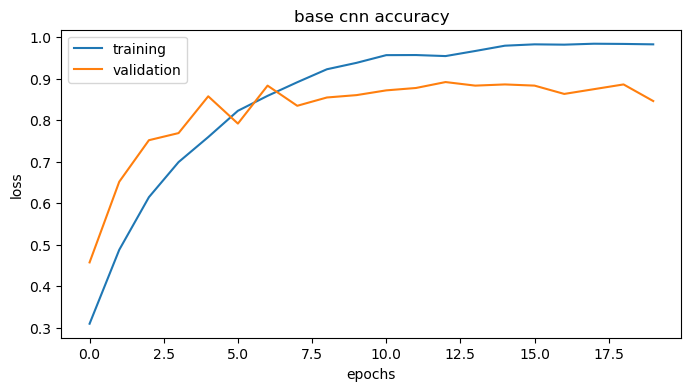

In [30]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')

plt.title('base cnn accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

It looks like a CNN would be an appropriate model and we can continue to hyper-parameter tuning.  

## hyper-parameter tuning<a id='hp'></a>

The goal with this tuning will be to explore several different combinations of parameters for our CNN to determine the optimal values.  This starts by defining the model layers, available parameter options and appropriate adjustments.

In [7]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()

        model.add(Conv2D(filters=hp.Int('conv_1_filters', min_value=32, max_value=256, step=32),
                         kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                         activation='relu', input_shape=self.input_shape))
        model.add(MaxPooling2D())
        model.add(Conv2D(filters=hp.Int('conv_1_filters', min_value=32, max_value=256, step=32),
                         kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                         activation='relu', input_shape=self.input_shape))
        model.add(MaxPooling2D())
        model.add(Conv2D(filters=hp.Int('conv_1_filters', min_value=32, max_value=256, step=32),
                         kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                         activation='relu', input_shape=self.input_shape))
        model.add(MaxPooling2D())
        model.add(Conv2D(filters=hp.Int('conv_1_filters', min_value=32, max_value=256, step=32),
                         kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                         activation='relu', input_shape=self.input_shape))
        model.add(MaxPooling2D())
        model.add(Conv2D(filters=hp.Int('conv_1_filters', min_value=32, max_value=256, step=32),
                         kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                         activation='relu', input_shape=self.input_shape))
        model.add(MaxPooling2D())
        
        model.add(Flatten())
        hp_units = hp.Int('dense_units', min_value=32, max_value=512, step=32)

        model.add(Dense(units=hp_units, activation='relu'))
        model.add(Dropout(0.5))  
        model.add(Dense(self.num_classes, activation='softmax'))

        hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        return model




Then our training and validation images are used to train and judge the accuracy of several of these parameters.

In [13]:
hypermodel = CNNHyperModel(input_shape=(256, 256, 3), num_classes=4)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=30,  # Number of trials to run
    executions_per_trial=2,  # Number of models to train for each trial
    directory='logs',
    project_name='keras_tuner_cnn'
)

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=50,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=50,
    class_mode='categorical'
)

tuner.search(train_generator, epochs=10, validation_data=val_generator)
best_model = tuner.get_best_models(num_models=1)[0]





Trial 30 Complete [00h 01m 39s]
val_accuracy: 0.8709273040294647

Best val_accuracy So Far: 0.8746867179870605
Total elapsed time: 01h 04m 57s
Epoch 1/100
80/80 [==============================] - 6s 60ms/step - loss: 0.3379 - accuracy: 0.8727 - val_loss: 0.3171 - val_accuracy: 0.8947
Epoch 2/100
80/80 [==============================] - 5s 58ms/step - loss: 0.2893 - accuracy: 0.8950 - val_loss: 0.3420 - val_accuracy: 0.8897
Epoch 3/100
80/80 [==============================] - 5s 58ms/step - loss: 0.2598 - accuracy: 0.9085 - val_loss: 0.3772 - val_accuracy: 0.8847
Epoch 4/100
80/80 [==============================] - 5s 58ms/step - loss: 0.2198 - accuracy: 0.9210 - val_loss: 0.4368 - val_accuracy: 0.8822
Epoch 5/100
80/80 [==============================] - 5s 58ms/step - loss: 0.2024 - accuracy: 0.9245 - val_loss: 0.3708 - val_accuracy: 0.8722
Epoch 6/100
80/80 [==============================] - 5s 58ms/step - loss: 0.1899 - accuracy: 0.9293 - val_loss: 0.4596 - val_accuracy: 0.8647
Epoch

Finally the model that had the best accuracy score is fully trained.

In [14]:
history = best_model.fit(train_generator, epochs=100, validation_data=val_generator)

Epoch 1/100
80/80 [==============================] - 5s 59ms/step - loss: 0.0440 - accuracy: 0.9868 - val_loss: 0.8778 - val_accuracy: 0.8922
Epoch 2/100
80/80 [==============================] - 5s 58ms/step - loss: 0.0406 - accuracy: 0.9895 - val_loss: 1.0321 - val_accuracy: 0.8997
Epoch 3/100
80/80 [==============================] - 5s 58ms/step - loss: 0.0304 - accuracy: 0.9915 - val_loss: 1.0443 - val_accuracy: 0.8822
Epoch 4/100
80/80 [==============================] - 5s 58ms/step - loss: 0.0308 - accuracy: 0.9902 - val_loss: 0.7613 - val_accuracy: 0.8772
Epoch 5/100
80/80 [==============================] - 5s 58ms/step - loss: 0.0466 - accuracy: 0.9870 - val_loss: 1.2141 - val_accuracy: 0.8672
Epoch 6/100
80/80 [==============================] - 5s 59ms/step - loss: 0.0609 - accuracy: 0.9847 - val_loss: 0.9536 - val_accuracy: 0.8722
Epoch 7/100
80/80 [==============================] - 5s 58ms/step - loss: 0.0442 - accuracy: 0.9893 - val_loss: 0.7361 - val_accuracy: 0.8972
Epoch 

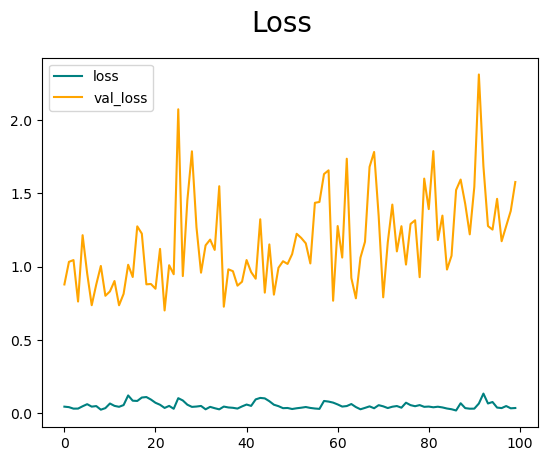

In [16]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
plt.legend(loc="upper left")
plt.show()

Hyper-parameter tuning did not improve the results and the base CNN model will be selected.

In [26]:
model.save(os.path.join('../models','bareCNN.keras'))